In [4]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [58]:
#required funstions

def matchwise_batsman_totalruns(df):

    #get total runs scored by batsman per match
    match_batsman_runs = df.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index()
    
    return match_batsman_runs

def matchwise_batsman_boundaries(df):
    
    #filter rows where only boundaries were scored
    df_boundaries = df[df.batsman_runs.isin([4,6])]

    #get total boundaries scored by batsman per match
    match_batsman_boundaries = df_boundaries.groupby(['match_id', 'batsman'])['batsman_runs'].agg(['sum','count']).reset_index()
    match_batsman_boundaries = match_batsman_boundaries.rename(columns={'sum':'total_boundary_runs', 'count':'boundary_count'})
    
    return match_batsman_boundaries

def matchwise_batsman_scored123(df):
    
    #filter rows where only boundaries were scored
    df_boundaries = df[df.batsman_runs.isin([1,2,3])]

    #get total boundaries scored by batsman per match
    match_batsman_boundaries = df_boundaries.groupby(['match_id', 'batsman'])['batsman_runs'].agg(['sum','count']).reset_index()
    match_batsman_boundaries = match_batsman_boundaries.rename(columns={'sum':'total_scored123_runs', 'count':'scored123_count'})
    
    return match_batsman_boundaries

def matchwise_batsman_ballsplayed(df):
    
    match_batsman_balls = df.groupby(['match_id', 'batsman'])['ball'].count().reset_index()
    
    return match_batsman_balls

def matchwise_batsman_strikerate(df):
    
    df_strike_rate = matchwise_batsman_totalruns(df).merge(matchwise_batsman_ballsplayed(df), on =['match_id','batsman'])
    df_strike_rate['strike_rate'] = np.round(df_strike_rate['batsman_runs']/df_strike_rate['ball']*100,3)
    return df_strike_rate[['match_id', 'batsman', 'strike_rate']]    



    

def matchwise_bowler_totovers(df):    
    
    match_bowler_totovers = df.groupby(['match_id', 'bowler'])['over'].nunique().reset_index()
    
    return match_bowler_totovers

def matchwise_bowler_gaveruns(df):
    
    match_bowler_gaveruns = df.groupby(['match_id', 'bowler'])['total_runs'].sum().reset_index()
    
    return match_bowler_gaveruns
    
    
def economy_rate(df):

    match_bowler_economyrate =  matchwise_bowler_gaveruns(df).merge(matchwise_bowler_totovers(df), on=['match_id', 'bowler'])
    
    return match_bowler_economyrate


def count_balls_toscore(df, score):
    """
    takes dataframe and scores needed by user abd returns array of balls taken to reach score every match
    """
    
    #counting total runs scored per ball
    df['total_runs_cumsum'] = df.groupby('match_id')['total_runs'].cumsum().values
    
    balls_taken = []
    

    #counting balls taken to score 50 runs by SRH team
    for m in df['match_id'].unique():
        df1 = df[df.match_id==m]

        if df1.total_runs_cumsum.isin(range(score,score+5)).any():
            df2 = df1[df1.total_runs_cumsum<=score]
            balls_taken.append(df2.shape[0])
            
        else:
            balls_taken.append(0)
            
    result = pd.DataFrame({'match_id' : df['match_id'].unique().tolist(), 
                          'balls_taken': balls_taken})
            
    return result
    


In [89]:
def matchwise_wickets_total(df):
    
    """
    takes filtered dataframe as input and returns matchwise wickets taken
    """
    
    wickets = df[df.player_dismissed.notnull()]
    
    #get wicket count matchwise
    wickets_count = wickets.groupby('match_id')['player_dismissed'].count().reset_index()
    wickets_count = wickets_count.rename(columns={'player_dismissed':'wicket_count'})

    return wickets_count
    

In [86]:
def get_dot_balls(df):
    """
    take data frame for total team matches and returns dot balls bowled by each bowler per match
    """

    #counting number of dot balls i,e where no wicket is taken neither runs are taken

    #total balls bowled by the bowler
    df_tot_balls = df.groupby(['match_id', 'bowler'])['total_runs'].count().reset_index()
    df_tot_balls = df_tot_balls.rename(columns={'total_runs': 'total_balls'})

    #total dots bowled by the bowler
    df_dots = df[(df.total_runs==0)|(df.player_dismissed==np.nan)]
    df_tot_dots = df_dots.groupby(['match_id', 'bowler'])['total_runs'].count().reset_index()
    df_tot_dots = df_tot_dots.rename(columns={'total_runs': 'total_dots'})

    df_dots_all = df_tot_balls.merge(df_tot_dots, how='left', on=['match_id', 'bowler'])
    
    return df_dots_all

In [41]:
# import data 
deliveries = pd.read_csv("deliveries.csv")
matches = pd.read_csv("matches.csv")


In [42]:
#rcb vs srh
#hyderabads team earlier was `deccan chargers` and now called `sunrisers hyderabad`
matches = matches.replace('Deccan Chargers', 'Sunrisers Hyderabad')
deliveries = deliveries.replace('Deccan Chargers', 'Sunrisers Hyderabad')

## 1. Who will win the match RCB or SRH?

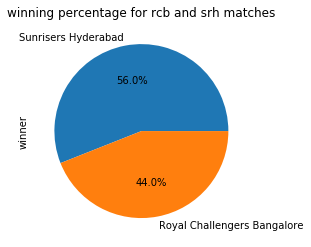

In [43]:
#get matches between rcb and srh
rcb_srh_matches = matches[((matches.team1=='Royal Challengers Bangalore')&(matches.team2=='Sunrisers Hyderabad'))|((matches.team2=='Royal Challengers Bangalore')&(matches.team1=='Sunrisers Hyderabad'))]

#getting wins count
rcb_srh_matches.winner.value_counts().plot(kind='pie', autopct='%1.1f%%', title="winning percentage for rcb and srh matches")

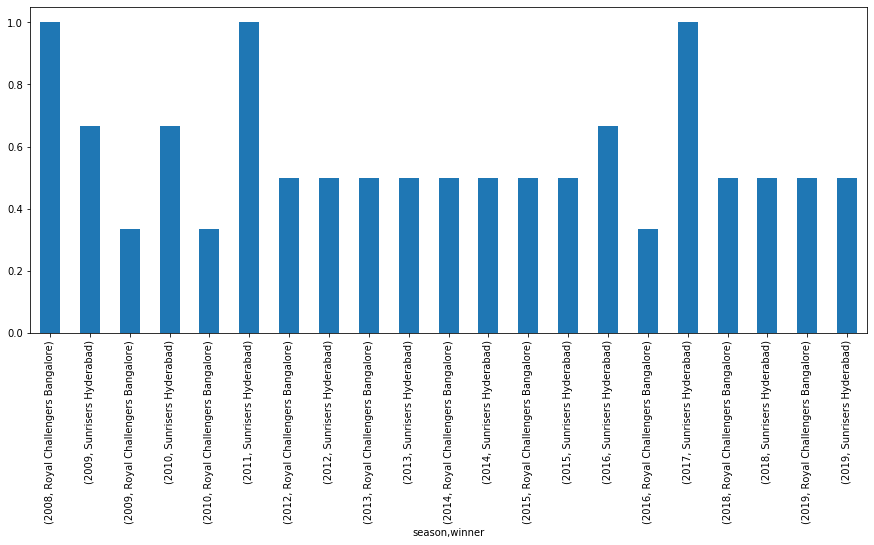

In [44]:
#getting matches between rcb nad srh matchwise
rcb_srh_matches.groupby('season')['winner'].value_counts(normalize=True).plot(kind='bar', figsize=(15,6))

In [45]:
def get_season_winpercent(team_name):
    """
    takes team name as input and returns season wise winning percent
    """

    #count matches played by rcb
    get_matches = matches[(matches.team1==team_name)|(matches.team2==team_name)]

    #getting matches played by team per season
    matches_played = get_matches.groupby('season')['id'].count().reset_index()
    matches_played = matches_played.rename(columns={'id': 'tot_matches_played' })

    #getting matches won by team per season
    matches_won = matches[matches.winner==team_name].groupby('season')['id'].count().reset_index()
    matches_won = matches_won.rename(columns={'id': 'tot_matches_won' })

    matches_wins = matches_played.merge(matches_won, on='season')
    matches_wins['winning_percent'] = matches_wins.tot_matches_won/matches_wins.tot_matches_played*100
    return matches_wins[['season', 'winning_percent']]

In [46]:
#get winning percent of rcb per season
rcb_winp = get_season_winpercent('Royal Challengers Bangalore')

#get winning percent of srh per season
srh_winp = get_season_winpercent('Sunrisers Hyderabad')


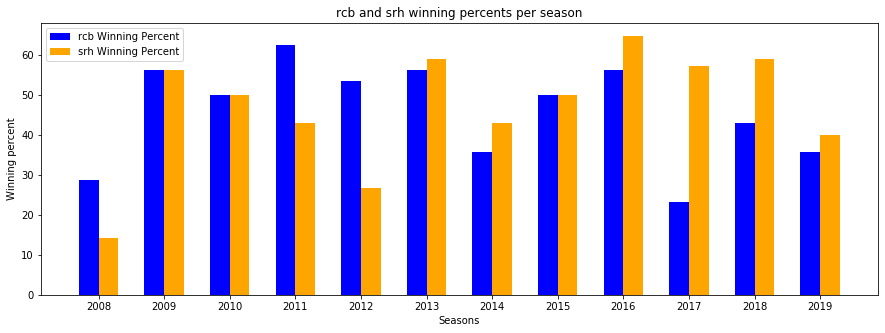

In [47]:
#checking visually
width=0.30
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(rcb_winp.season-width/2, rcb_winp.winning_percent, width , color='b', label='rcb Winning Percent')
ax.bar(srh_winp.season+width/2, srh_winp.winning_percent, width,  color='orange', label='srh Winning Percent')
plt.xlabel("Seasons")
plt.ylabel("Winning percent")
plt.title("rcb and srh winning percents per season")
plt.xticks(np.arange(2008,2020))
plt.legend()
plt.show()

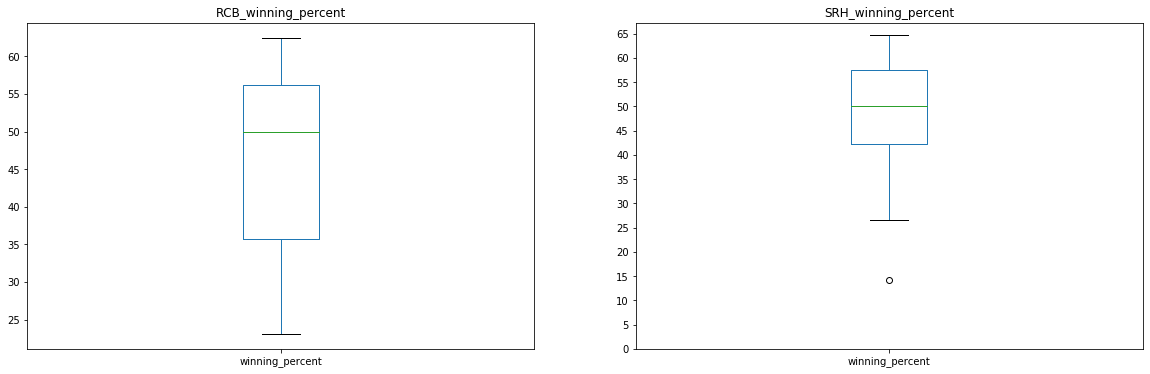

In [48]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
rcb_winp.winning_percent.plot('box', ax=ax[0], title='RCB_winning_percent')
srh_winp.winning_percent.plot('box', ax=ax[1], title='SRH_winning_percent')
plt.yticks(ticks=[0,5,10,15,20,25,30,35,40,45,50,55,60,65]);

**Inference:**
    We can see RCB and SRH seem to have similar winning percentages across seasons sometimes RCB overperformed whereas sometimes SRH in the recent season had a higher winning percent. However if we check overall winning percentage RCB seems to be leading.

###  2. How many runs will be scored in total in todays match? 

In [54]:
#get all matches between rcb and srh
rcb_srh_all = deliveries[((deliveries.bowling_team=='Royal Challengers Bangalore')&(deliveries.batting_team=='Sunrisers Hyderabad'))|((deliveries.bowling_team=='Sunrisers Hyderabad')&(deliveries.batting_team=='Royal Challengers Bangalore'))]

In [55]:
# get matchwise total runs for the two teams and them up
match_totalruns = matchwise_batsman_totalruns(rcb_srh_all).groupby('match_id')['batsman_runs'].sum()

match_totalruns.describe()

count     25.000000
mean     312.440000
std       58.086918
min      161.000000
25%      287.000000
50%      313.000000
75%      353.000000
max      422.000000
Name: batsman_runs, dtype: float64

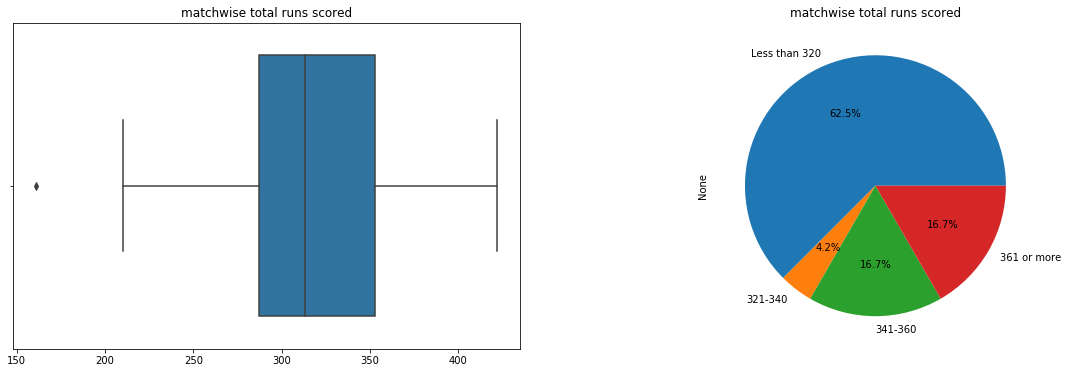

In [56]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('matchwise total runs scored')
sns.boxplot(match_totalruns.values, ax=ax[0])

pd.cut(match_totalruns.values, bins=[0,321, 341, 361, 400], labels=['Less than 320', '321-340', '341-360', '361 or more']).value_counts().plot("pie", autopct='%1.1f%%', title='matchwise total runs scored', ax=ax[1]);

**Inference:**
    If we check matchwise total how many runs were scored by both teams on average the teams score less than 320.

## 3. How many balls more/less will RCB take to reach a score total of 30 runs from after they reach a team total of 50 as compared to SRH?
 * 0-8
 * 9-15
 * 16-20
 * 21 or more

In [67]:
# rcb_srh_all.head()

In [68]:
# get all rows when RCB was batting and SRH bowled
rcb_bats = rcb_srh_all[(rcb_srh_all.batting_team=='Royal Challengers Bangalore')&(rcb_srh_all.bowling_team=='Sunrisers Hyderabad')]

# get total balls taken to score 30 runs per match
rcb_toscore30 = count_balls_toscore(rcb_bats, 30)

rcb_toscore30['balls_taken'].describe()

count    25.000000
mean     25.840000
std       9.168242
min       0.000000
25%      22.000000
50%      26.000000
75%      31.000000
max      44.000000
Name: balls_taken, dtype: float64

In [69]:
# get all rows when srh was batting and rcb bowled
srh_bats = rcb_srh_all[(rcb_srh_all.batting_team=='Sunrisers Hyderabad')&(rcb_srh_all.bowling_team=='Royal Challengers Bangalore')]

# get total balls taken to score 30 runs per match
srh_toscore30 = count_balls_toscore(srh_bats, 30)

srh_toscore30['balls_taken'].describe()

count    25.000000
mean     24.400000
std      11.150486
min       0.000000
25%      19.000000
50%      25.000000
75%      30.000000
max      47.000000
Name: balls_taken, dtype: float64

In [76]:
rcb_srh_toscore30 = rcb_toscore30.merge(srh_toscore30, on='match_id', suffixes=(['_rcb', '_srh']))

rcb_srh_toscore30['difference'] = np.abs(rcb_srh_toscore30['balls_taken_srh']-rcb_srh_toscore30['balls_taken_rcb'])

rcb_srh_toscore30['difference'].describe()

count    25.000000
mean     11.360000
std       9.132725
min       1.000000
25%       4.000000
50%       8.000000
75%      15.000000
max      29.000000
Name: difference, dtype: float64

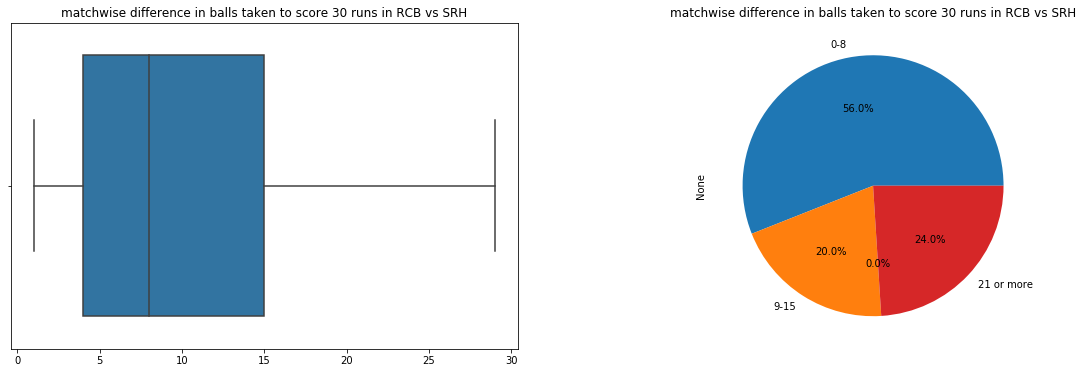

In [78]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('matchwise difference in balls taken to score 30 runs in RCB vs SRH')
sns.boxplot(rcb_srh_toscore30['difference'].values, ax=ax[0])

pd.cut(rcb_srh_toscore30['difference'].values, bins=[0,9, 16, 21, 30], labels=['0-8', '9-15', '16-20', '21 or more']).value_counts().plot("pie", autopct='%1.1f%%', title='matchwise difference in balls taken to score 30 runs in RCB vs SRH', ax=ax[1]);

**Inference:**
    If we calculate matchwise average difference is 7 balls infact even if see the probability of 0-8 balls 56% which is dominant than other options.

### 4. How many wickets more/less will SRH lose as compared to RCB in the powerplay?

    * 0-1
    * 2-3
    * 4
    * 5 or more

In [87]:
# get all rows when RCB was batting and SRH bowled
rcb_bats = rcb_srh_all[(rcb_srh_all.batting_team=='Royal Challengers Bangalore')&(rcb_srh_all.bowling_team=='Sunrisers Hyderabad')]

# get all rows when srh was batting and rcb bowled
srh_bats = rcb_srh_all[(rcb_srh_all.batting_team=='Sunrisers Hyderabad')&(rcb_srh_all.bowling_team=='Royal Challengers Bangalore')]

# get only powerplay rows RCB
rcb_bats_powerplay = rcb_bats[rcb_bats.over.isin(range(1,7))]

# get only powerplay rows SRH
srh_bats_powerplay = srh_bats[srh_bats.over.isin(range(1,7))]
    

In [99]:
#get wickets lost by RCB per match in powerplay
rcb_wickets_powerplay = matchwise_wickets_total(rcb_bats_powerplay)

#get wickets lost by SRH per match in powerplay
srh_wickets_powerplay = matchwise_wickets_total(srh_bats_powerplay)

#get wickets lost by both SRH and RCB during powerplay and their difference
rcb_srh_wickets_powerplay = rcb_wickets_powerplay.merge(srh_wickets_powerplay, on=['match_id'], suffixes=['_rcb', '_srh'])

#getting absolute of difference in wickets lost by the teams
rcb_srh_wickets_powerplay['difference'] = np.abs(rcb_srh_wickets_powerplay.wicket_count_srh - rcb_srh_wickets_powerplay.wicket_count_rcb)

rcb_srh_wickets_powerplay['difference'].describe()

count    17.000000
mean      0.882353
std       0.927520
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: difference, dtype: float64

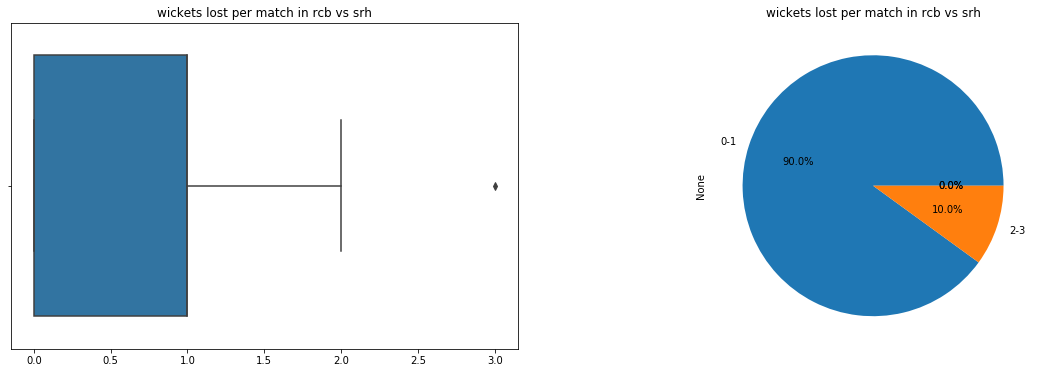

In [101]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('wickets lost per match in rcb vs srh')
sns.boxplot(rcb_srh_wickets_powerplay.difference.values, ax=ax[0])

pd.cut(rcb_srh_wickets_powerplay.difference.values, bins=[0,2, 4, 5, 10], labels=['0-1', '2-3', '4', '5 or more']).value_counts().plot("pie", autopct='%1.1f%%', title='wickets lost per match in rcb vs srh', ax=ax[1]);

**Inference:**
    If we check absolute difference in wickets lost SRH and RCB in powerplay the average is close to 0-1 also if we check the probability the highest probability indicates wickets lost is 0-1. 

### 5. How many dot balls will be bowled in the entire match?
    * Less than 60
    * 60-80
    * 81-110
    * 111 or more

In [80]:
# get dot balls bowled in rcb and srh matches
rcb_srh_dots = get_dot_balls(rcb_srh_all)

# counting total dots per match
rcb_srh_dots_count = rcb_srh_dots.groupby('match_id')['total_dots'].sum()

# checking the stats
rcb_srh_dots_count.describe()

count     25.000000
mean      81.640000
std       16.957987
min       20.000000
25%       76.000000
50%       82.000000
75%       88.000000
max      107.000000
Name: total_dots, dtype: float64

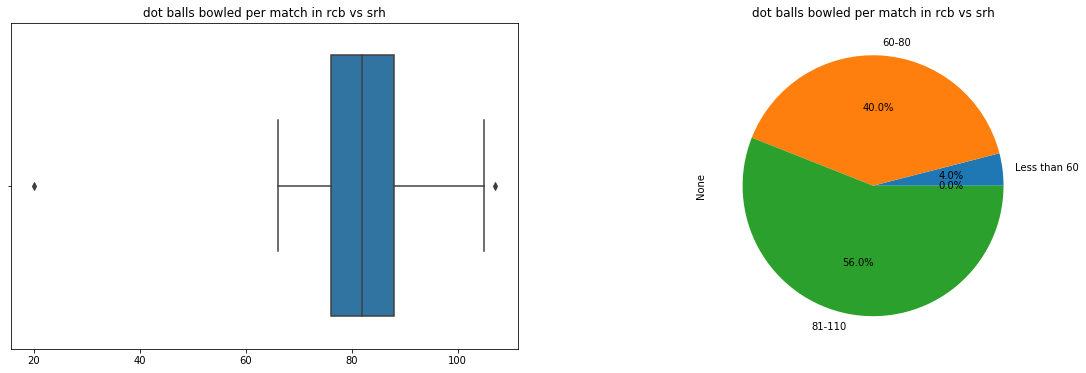

In [83]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('dot balls bowled per match in rcb vs srh')
sns.boxplot(rcb_srh_dots_count.values, ax=ax[0])

pd.cut(rcb_srh_dots_count.values, bins=[0,60, 81, 111, 200], labels=['Less than 60', '60-80', '81-110', '111 or more']).value_counts().plot("pie", autopct='%1.1f%%', title='dot balls bowled per match in rcb vs srh', ax=ax[1]);

**Inference:**
    If we calculate dot balls bowled per match by both teams and check statistics we get 81 as an average and for probability for options 81-110 will be the safest option has highest probability to have dot balls in this range.